# XLK Next-Day Nowcast
Predict tomorrow's return of XLK (Technology ETF) using simple features:
 - Market controls: SPY, VIX
 - Momentum & volatility features on XLK
This is a learning project for Python + basic ML on time series.

In [26]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Executable: c:\Users\nadoy\OneDrive\Desktop\DS PROJECTS\stock-nowcast\.venv\Scripts\python.exe


In [27]:
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from joblib import dump

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


Download Prices (XLK target, SPY & VIX as features)

In [28]:
tickers = ["XLK", "SPY", "^VIX"] # Tech sector, market, volatility
px = yf.download(tickers, start="2015-01-01", auto_adjust=True, threads=False)["Close"].dropna()
px.columns = ["XLK", "SPY", "VIX"]
px.head

[*********************100%***********************]  3 of 3 completed


<bound method NDFrame.head of                   XLK        SPY       VIX
Date                                      
2015-01-02 171.567993  36.315063 17.790001
2015-01-05 168.469574  35.760696 19.920000
2015-01-06 166.882782  35.329525 21.120001
2015-01-07 168.962296  35.628696 19.309999
2015-01-08 171.960587  36.411858 17.010000
...               ...        ...       ...
2025-08-11 635.919983 264.119995 16.250000
2025-08-12 642.690002 268.209991 14.730000
2025-08-13 644.890015 268.309998 14.490000
2025-08-14 644.950012 267.730011 14.830000
2025-08-15 643.440002 265.700012 15.090000

[2671 rows x 3 columns]>

In [29]:
# Daily returns
ret = px.pct_change().dropna()
ret.columns = ["ret_xlk", "ret_spy", "ret_vix"]

# Feature table
feat = pd.DataFrame(index=ret.index)
feat["ret_xlk"] = ret["ret_xlk"]
feat["ret_spy"] = ret["ret_spy"]
feat["ret_vix"] = ret["ret_vix"]

# Momentum and volatility features on XLK
feat["mom_5"] = ret["ret_xlk"].rolling(5).mean()
feat["mom_10"] = ret["ret_xlk"].rolling(10).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat["vol_20"] = ret["ret_xlk"].rolling(20).std()

feat = feat.dropna()

# Shift featuers by 1 day so they're known before predicting next day
X = feat[["ret_spy", "ret_vix", "mom_5", "mom_10", "vol_10", "vol_20"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]

X.tail(), y.tail()

(             ret_spy   ret_vix    mom_5    mom_10   vol_10   vol_20
 Date                                                               
 2025-08-11  0.009989 -0.085697 0.004950  0.000046 0.008617 0.006526
 2025-08-12 -0.006769  0.072607 0.001514 -0.000127 0.008640 0.006558
 2025-08-13  0.015485 -0.093538 0.004658  0.001202 0.009214 0.006783
 2025-08-14  0.000373 -0.016293 0.003810  0.001670 0.009194 0.006784
 2025-08-15 -0.002162  0.023464 0.003996  0.002054 0.009021 0.006709,
 Date
 2025-08-11   -0.001977
 2025-08-12    0.010646
 2025-08-13    0.003423
 2025-08-14    0.000093
 2025-08-15   -0.002341
 Name: ret_xlk, dtype: float64)

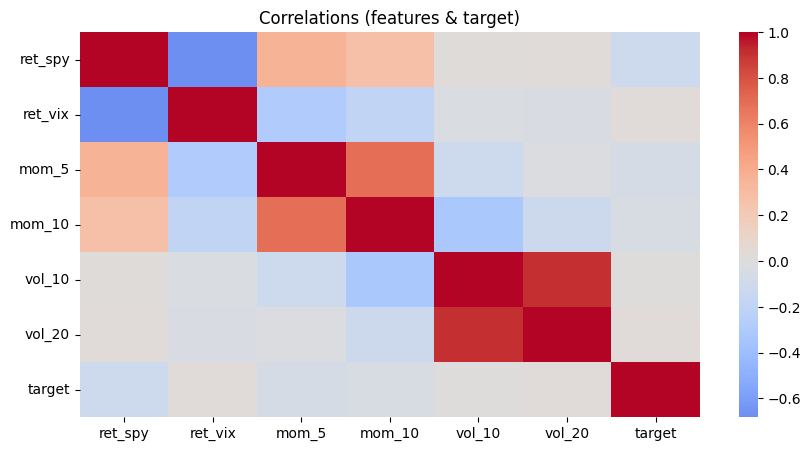

In [30]:
sns.heatmap(pd.concat([X, y.rename("target")], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlations (features & target)"); plt.show()


In [31]:
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
len(X_train), len(X_test)


(2120, 530)

In [32]:
def evaluate_preds(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # returns MSE
    rmse = np.sqrt(mse)                       # convert to RMSE manually
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}


baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

print("Baseline Zero:", evaluate_preds(y_test, baseline_zero))
print("Baseline Lag-1:", evaluate_preds(y_test, baseline_lag1))


Baseline Zero: {'MAE': 0.00667469494172185, 'RMSE': np.float64(0.010222827645350348), 'Directional_Accuracy': np.float64(0.0018867924528301887)}
Baseline Lag-1: {'MAE': 0.009774697357858823, 'RMSE': np.float64(0.014938761985500338), 'Directional_Accuracy': np.float64(0.5094339622641509)}


In [33]:
ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, max_iter=10000))])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

print("Ridge:", evaluate_preds(y_test, pred_ridge))
print("Lasso:", evaluate_preds(y_test, pred_lasso))


Ridge: {'MAE': 0.006703179335177877, 'RMSE': np.float64(0.010150787088937307), 'Directional_Accuracy': np.float64(0.5264150943396226)}
Lasso: {'MAE': 0.0066547066946041995, 'RMSE': np.float64(0.010180341261642571), 'Directional_Accuracy': np.float64(0.5528301886792453)}


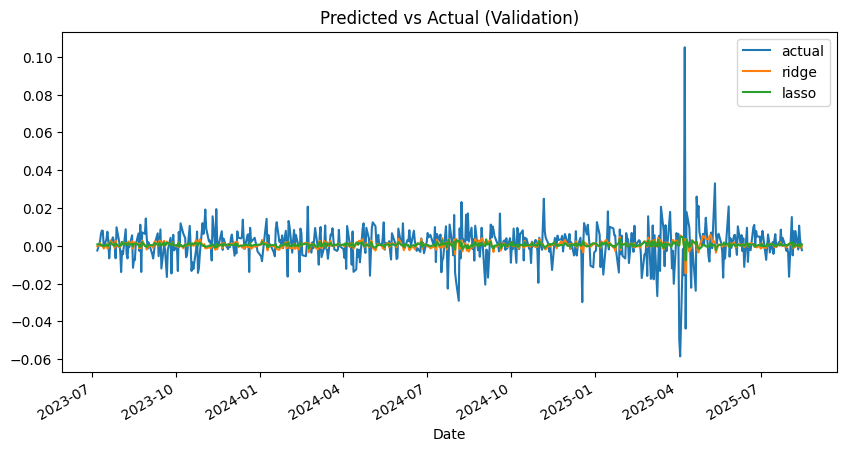

In [34]:
pd.DataFrame({"actual": y_test, "ridge": pred_ridge, "lasso": pred_lasso}).plot()
plt.title("Predicted vs Actual (Validation)"); plt.show()


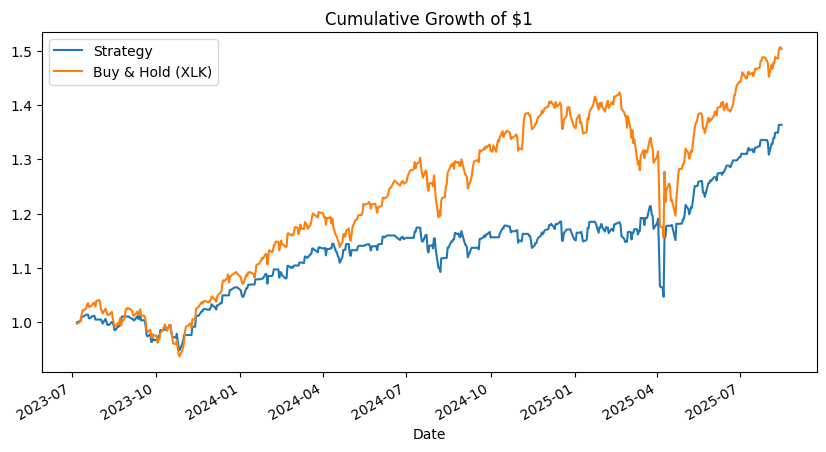

Strategy CAGR-ish: 15.88% | Buy&Hold: 21.36%


In [35]:
pred = pd.Series(pred_ridge, index=y_test.index, name="pred")
signal = (pred > 0).astype(int)          # 1=long, 0=flat
strat_ret = signal * y_test

cum_strat = (1 + strat_ret).cumprod()
cum_buyhold = (1 + y_test).cumprod()

ax = cum_strat.plot(label="Strategy")
cum_buyhold.plot(ax=ax, label="Buy & Hold (XLK)")
plt.legend(); plt.title("Cumulative Growth of $1"); plt.show()

strategy_cagr = cum_strat.iloc[-1]**(252/len(cum_strat)) - 1
buyhold_cagr  = cum_buyhold.iloc[-1]**(252/len(cum_buyhold)) - 1
print(f"Strategy CAGR-ish: {strategy_cagr:.2%} | Buy&Hold: {buyhold_cagr:.2%}")


In [36]:
dump(ridge, "../reports/ridge_model.joblib")
X_test.to_csv("../data/test_features.csv")
y_test.to_csv("../data/test_target.csv")


In [37]:
tickers = ["XLK", "SPY", "^VIX", "QQQ", "SOXX"]
px = yf.download(tickers, start="2015-01-01", auto_adjust=True)["Close"].dropna()
px.columns = ["XLK","SPY","VIX","QQQ","SOXX"]

ret = px.pct_change().dropna().rename(columns={
    "XLK":"ret_xlk", "SPY":"ret_spy", "VIX":"ret_vix", "QQQ":"ret_qqq", "SOXX":"ret_soxx"
})

feat = pd.DataFrame(index=ret.index)
for col in ["ret_xlk","ret_spy","ret_vix","ret_qqq","ret_soxx"]:
    feat[col] = ret[col]
feat["mom_5"]  = ret["ret_xlk"].rolling(5).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat = feat.dropna()

X = feat[["ret_spy","ret_vix","ret_qqq","ret_soxx","mom_5","vol_10"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]


[*********************100%***********************]  5 of 5 completed
